In [30]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
import io
import tensorflow as tf
from TP1_data.KalmanFilter import KalmanFilter
from scipy.optimize import linear_sum_assignment
#from KalmanFilter import KalmanFilter

In [31]:
# load detection
path = 'Filemail.com files 14.12.2023 fbhubejonusmcri/ADL-Rundle-6/det/det.txt'

# data
data = open(path, 'r').read()

# Column names as specified
column_names = ["frame", "id", "bb_left", "bb_top", "bb_width", "bb_height", "conf", "x", "y", "z"]

# Creating a DataFrame from the data
df = pd.read_csv(io.StringIO(data), names=column_names, header=None)
df.head(12)  # Displaying the first few rows of the DataFrame

,frame,id,bb_left,bb_top,bb_width,bb_height,conf,x,y,z
0,1,-1,1689,385,146.620,332.710,67.5670,-1,-1,-1
1,1,-1,1303,503,61.514,139.590,29.4390,-1,-1,-1
2,1,-1,1258,569,40.123,91.049,19.6010,-1,-1,-1
3,1,-1,31,525,113.370,257.270,17.0130,-1,-1,-1
4,1,-1,1800,483,94.660,214.810,11.9490,-1,-1,-1
5,2,-1,1689,385,146.620,332.710,66.7250,-1,-1,-1
6,2,-1,1312,503,61.514,139.590,36.6140,-1,-1,-1
7,2,-1,1744,476,123.420,280.060,16.9760,-1,-1,-1
8,2,-1,1254,537,52.000,118.000,15.9790,-1,-1,-1
9,2,-1,55,542,94.660,214.810,9.3326,-1,-1,-1


In [32]:
# example init kalman filter
def create_kalman():
    dt = 0.1
    u_x = 0
    u_y = 0
    std_acc = 1
    x_sdt_meas = 0.1
    y_sdt_meas = 0.1
    kalman = KalmanFilter(dt, u_x, u_y, std_acc, x_sdt_meas, y_sdt_meas)
    return kalman

In [33]:
def compute_iou(boxA, boxB):
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

# Convert the bounding box from [left, top, width, height] to [x1, y1, x2, y2]
df['x1'] = df['bb_left']
df['y1'] = df['bb_top']
df['x2'] = df['bb_left'] + df['bb_width']
df['y2'] = df['bb_top'] + df['bb_height']



In [34]:
df_frame1 = df[df['frame'] == 1]
df_frame2 = df[df['frame'] == 2]

def compute_iou_matrix(df_frame1, df_frame2):
    # Initialize an empty matrix for IoU between frame 1 and frame 2
    iou_matrix_frame1_frame2 = pd.DataFrame(np.zeros((len(df_frame1), len(df_frame2))), index=df_frame1.index,
                                            columns=df_frame2.index)
    # Compute IoU for each pair of bounding boxes between frame 1 and frame 2
    for i in df_frame1.index:
        boxA = df_frame1.loc[i, ['x1', 'y1', 'x2', 'y2']]
        for j in df_frame2.index:
            boxB = df_frame2.loc[j, ['x1', 'y1', 'x2', 'y2']]
            iou_matrix_frame1_frame2.at[i, j] = compute_iou(boxA, boxB)
    return iou_matrix_frame1_frame2

iou_matrix_frame1_frame2 = compute_iou_matrix(df_frame1, df_frame2)
# display the IoU matrix
print(iou_matrix_frame1_frame2)

         5         6         7         8         9    10
0  1.000000  0.000000  0.361845  0.000000  0.000000  0.0
1  0.000000  0.744732  0.000000  0.021989  0.000000  0.0
2  0.000000  0.000000  0.000000  0.544377  0.000000  0.0
3  0.000000  0.000000  0.000000  0.000000  0.633519  0.0
4  0.124487  0.000000  0.358332  0.000000  0.000000  0.0


In [35]:
def compute_embedings(boxes, img, model):
    embedings = []
    # get the sub part of the image for each box
    for i in boxes.index:
        box = boxes.loc[i, ['x1', 'y1', 'x2', 'y2']]
        box = box.astype(int)

        # check if the box is valid
        if box[0] < 0:
            box[0] = 0
        if box[1] < 0:
            box[1] = 0
        if box[2] > img.shape[1]:
            box[2] = img.shape[1]
        if box[3] > img.shape[0]:
            box[3] = img.shape[0]
        patch = img[box[1]:box[3], box[0]:box[2]]

        # resize the patch to 224x224
        patch = cv2.resize(patch, (224, 224))

        # convert to RGB
        patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)

        # convert to float
        patch = patch.astype(float)

        # normalize the patch
        patch /= 255.0

        # use the pre-trained model to extract the features
        patch = np.expand_dims(patch, axis=0)
        patch = model.predict(patch)
        patch = np.squeeze(patch)

        # append the features to the list of features
        embedings.append(patch)

    return embedings

model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

image = cv2.imread('Filemail.com files 14.12.2023 fbhubejonusmcri/ADL-Rundle-6/img1/000001.jpg')
embedings = compute_embedings(df_frame1, image, model)

# display the shape of the features
print(embedings[0].shape)
print(len(embedings))

1/1 [==============================] - 0s 77ms/step
(7, 7, 512)
5


In [36]:
def dist_embedings(embeding1, embeding2):
    return np.linalg.norm(embeding1 - embeding2)

def compute_dist_matrix(df_frame1, df_frame2, image1, image2, model):
    # Initialize an empty matrix for distances between frame 1 and frame 2
    dist_matrix_frame1_frame2 = pd.DataFrame(np.zeros((len(df_frame1), len(df_frame2))), index=df_frame1.index,
                                             columns=df_frame2.index)

    embedings1 = compute_embedings(df_frame1, image1, model)
    embedings2 = compute_embedings(df_frame2, image2, model)
    # Compute distances for each pair of bounding boxes between frame 1 and frame 2
    for i in range(len(df_frame1)):
        for j in range(len(df_frame2)):
            i_index = df_frame1.index[i]
            j_index = df_frame2.index[j]
            dist_matrix_frame1_frame2.at[i_index, j_index] = dist_embedings(embedings1[i], embedings2[j])

    return dist_matrix_frame1_frame2
image1 = image
image2 = cv2.imread('Filemail.com files 14.12.2023 fbhubejonusmcri/ADL-Rundle-6/img1/000002.jpg')
dist_matrix_frame1_frame2 = compute_dist_matrix(df_frame1, df_frame2, image1, image2, model)
# display the distance matrix
print(dist_matrix_frame1_frame2)


1/1 [==============================] - 0s 70ms/step
          5          6          7          8          9          10
0  19.629091  47.639347  48.857929  49.181980  47.904743  48.657475
1  48.432415  26.519157  47.623394  41.012535  41.698673  38.607536
2  48.445724  36.737003  42.625557  30.035177  38.289688  27.420506
3  48.781109  41.501282  45.493465  42.514759  31.318941  39.351791
4  48.570000  40.235073  42.962437  43.540619  42.428474  39.535049


In [37]:
def is_similar_size_and_shape(boxA, boxB, size_threshold=0.5, ratio_threshold=0.5):
    # Calculate areas and aspect ratios
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    ratioA = (boxA[2] - boxA[0]) / float(boxA[3] - boxA[1])
    ratioB = (boxB[2] - boxB[0]) / float(boxB[3] - boxB[1])

    # Compare areas and aspect ratios
    area_similar = min(areaA, areaB) / float(max(areaA, areaB)) > size_threshold
    ratio_similar = min(ratioA, ratioB) / float(max(ratioA, ratioB)) > ratio_threshold

    return area_similar and ratio_similar


In [38]:
sigma = 0.5

def associate_detections_to_tracks(iou_matrix, embeddings_matrix, df_frame1, df_frame2, sigma=0.5, alpha=0.6, beta=0.4):
    # Check shapes
    if iou_matrix.shape != embeddings_matrix.shape:
        print('iou_matrix and embeddings_matrix must have the same shape', iou_matrix.shape, embeddings_matrix.shape)
        return {}

    # Normalize IoU and embedding distances to a similar scale
    max_iou = max(iou_matrix.max().max(), 1) # Ensure no division by zero
    max_dist = max(embeddings_matrix.max().max(), 1)

    normalized_iou_matrix = iou_matrix / max_iou
    normalized_embeddings_matrix = 1 - (embeddings_matrix / max_dist) # Inverting the embeddings score

    # Create a combined score matrix
    combined_score_matrix = alpha * normalized_iou_matrix + beta * normalized_embeddings_matrix

    # Use Hungarian algorithm on the combined score matrix
    row_ind, col_ind = linear_sum_assignment(-combined_score_matrix.values)
    associations = {}

    for i in range(len(row_ind)):
        row = row_ind[i]
        col = col_ind[i]

        boxA = df_frame1.loc[combined_score_matrix.index[row], ['x1', 'y1', 'x2', 'y2']]
        boxB = df_frame2.loc[combined_score_matrix.columns[col], ['x1', 'y1', 'x2', 'y2']]

        # Check if boxes have similar size and shape
        if is_similar_size_and_shape(boxA, boxB) and combined_score_matrix.iloc[row, col] > sigma:
            associations[combined_score_matrix.index[row]] = combined_score_matrix.columns[col]

    return associations



# Example usage
associations_frame1_frame2 = associate_detections_to_tracks(iou_matrix_frame1_frame2, dist_matrix_frame1_frame2, df_frame1, df_frame2, sigma=0.5, alpha=0.6, beta=0.4)
associations_frame1_frame2



{0: 5, 1: 6, 3: 9}

In [39]:
# Initialize lists for matches, unmatched detections, and unmatched tracks
matches = []
unmatched_detections = list(df_frame2.index)
unmatched_tracks = list(df_frame1.index)

# Populate the lists based on the associations
for track_idx, detection_idx in associations_frame1_frame2.items():
    if detection_idx in unmatched_detections:
        # Add to matches and remove from unmatched lists
        matches.append((track_idx, detection_idx))
        unmatched_detections.remove(detection_idx)
    unmatched_tracks.remove(track_idx)

# Matches, unmatched detections, and unmatched tracks after processing
matches, unmatched_detections, unmatched_tracks


([(0, 5), (1, 6), (3, 9)], [7, 8, 10], [2, 4])

In [40]:
def track_management_with_unique_ids(df, frame_range, frames, sigma=0.5):
    results = {}
    current_ids = {}
    next_id = 0
    history = {}
    filters = {}

    for frame in range(frame_range[0], frame_range[1]):
        print("======================================================================= frame ", frame, "=======================================================================")
        image1 = frames[frame - 1]
        image2 = frames[frame]

        #print('image1', image1.shape)
        #print('image2', image2.shape)
 
        df_current_frame = df[df['frame'] == frame]
        df_next_frame = df[df['frame'] == frame + 1]

        if df_current_frame.empty or df_next_frame.empty:
            continue

        iou_matrix = compute_iou_matrix(df_current_frame, df_next_frame)
        iou_matrix = iou_matrix.apply(pd.to_numeric)

        dist_matrix = compute_dist_matrix(df_current_frame, df_next_frame, image1, image2, model)
        dist_matrix = dist_matrix.apply(pd.to_numeric)

        associations = associate_detections_to_tracks(iou_matrix, dist_matrix, df_current_frame, df_next_frame, sigma=sigma)
        matches = []
        unmatched_detections = list(df_next_frame.index)
        unmatched_tracks = list(df_current_frame.index)

        for track_idx, detection_idx in associations.items():
            if detection_idx in unmatched_detections:
                track_id = current_ids.get(track_idx, next_id)
                if track_id not in filters:
                    filters[track_id] = create_kalman()  # Initialize a Kalman filter for the new track ID
                    next_id += 1

                current_ids[detection_idx] = track_id
                matches.append((track_id, detection_idx))
                unmatched_detections.remove(detection_idx)

                # Update Kalman filter for existing tracks
                if track_id in filters:
                    kalman = filters[track_id]
                    # Update kalman filter with current data
                    bb_left = df.loc[track_id, 'bb_left']
                    bb_top = df.loc[track_id, 'bb_top']
                    kalman.update([[bb_left], [bb_top]])
                    prediction = kalman.predict()
                    df.loc[track_id, 'bb_left'] = prediction[0]
                    df.loc[track_id, 'bb_top'] = prediction[1]
                    #update x1, y1, x2, y2
                    df.loc[track_id, 'x1'] = prediction[0]
                    df.loc[track_id, 'y1'] = prediction[1]
                    df.loc[track_id, 'x2'] = prediction[0] + df.loc[track_id, 'bb_width']
                    df.loc[track_id, 'y2'] = prediction[1] + df.loc[track_id, 'bb_height']
                    #print('update', track_id, 'former', bb_left, bb_top, 'new', prediction[0], prediction[1])


        for detection_idx in unmatched_detections:
            current_ids[detection_idx] = next_id
            filters[next_id] = create_kalman()  # Initialize a Kalman filter for the new detection
            next_id += 1

        for track_idx in unmatched_tracks:
            if track_idx in current_ids:
                del current_ids[track_idx]
            if track_idx in filters:
                del filters[track_idx]

        results[frame] = {
            'matches': matches,
            'unmatched_detections': unmatched_detections,
            'unmatched_tracks': unmatched_tracks
        }
        #print('results', results[frame])
        #print('filters', filters.keys())

        for track_idx, detection_idx in matches:
            if track_idx in history:
                history[track_idx].append(detection_idx)
            else:
                history[track_idx] = [detection_idx]

    return results, next_id, history

# Apply the modified track management to our data
frame_range = (1, 12)
frames = []
for frame in range(frame_range[0], frame_range[1] + 1):
    image = cv2.imread('Filemail.com files 14.12.2023 fbhubejonusmcri/ADL-Rundle-6/img1/{:06d}.jpg'.format(frame))
    frames.append(image)
track_management_results, _, history = track_management_with_unique_ids(df, frame_range, frames, sigma=0.5)
print(track_management_results)
print(history)



======================================================================= frame  1 =======================================================================
1/1 [==============================] - 0s 70ms/step
======================================================================= frame  2 =======================================================================
1/1 [==============================] - 0s 78ms/step
======================================================================= frame  3 =======================================================================
1/1 [==============================] - 0s 81ms/step
======================================================================= frame  4 =======================================================================
1/1 [==============================] - 0s 71ms/step
======================================================================= frame  5 =======================================================================
1/1 [======================

{0: [5], 1: [6, 13, 21], 2: [9, 17, 23], 9: [18], 10: [19], 12: [22], 15: [25, 29, 35, 42, 47, 57], 18: [31], 19: [28, 34, 40, 45, 52, 58, 64], 25: [41, 46, 53, 59, 65], 30: [51, 55, 60], 32: [54], 33: [56, 61], 35: [67]}


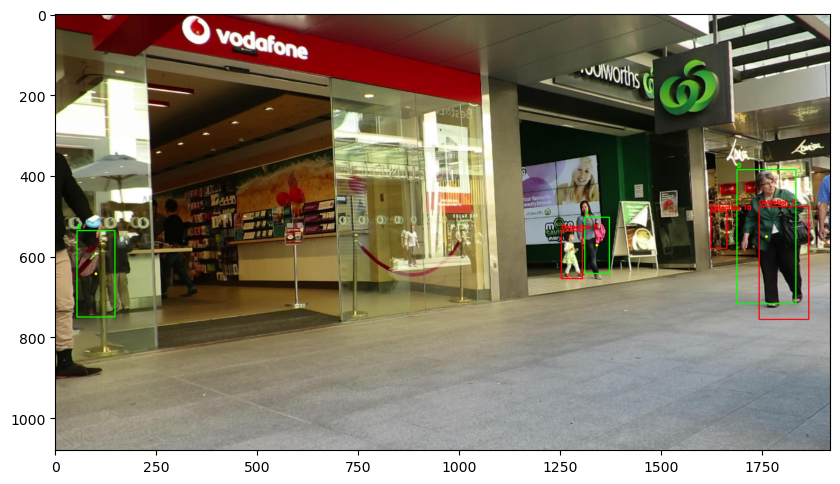

In [41]:
# Function to draw bounding boxes, IDs, and trajectories
def draw_tracking_info(df, image, matches, unmatched_detections, unmatched_tracks, history):
    # Define colors
    color_matched = (0, 255, 0)  # Green for matched
    color_unmatched_detection = (0, 0, 255)  # Red for unmatched detection
    color_unmatched_track = (255, 0, 0)  # Blue for unmatched track
    color_line = (0, 255, 255)  # Yellow for trajectory line
    
    # Draw matched tracks and their trajectories
    for track_idx, detection_idx in matches:
        # Get the bounding box of the detection
        bb_left = int(df.loc[detection_idx, 'bb_left'])
        bb_top = int(df.loc[detection_idx, 'bb_top'])
        bb_width = int(df.loc[detection_idx, 'bb_width'])
        bb_height = int(df.loc[detection_idx, 'bb_height'])
        
        # Draw the bounding box
        cv2.rectangle(image, (bb_left, bb_top), (bb_left + bb_width, bb_top + bb_height), color_matched, 2)
        
        # Annotate the bounding box with the track ID
        cv2.putText(image, str(track_idx), (bb_left, bb_top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_matched, 2)
        
        # get the track ID
        #track_id = int(df.loc[track_idx, 'id'])
        
        
        # Annotate the image with the track ID
        #cv2.putText(image, 'Track ' + str(track_id), (cx + 5, cy + 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_matched, 2)
        
        #print(track_idx)
        # Draw the trajectory line
        if track_idx in history:
            #print(history[track_idx])
            cx = None
            cy = None
            for detection_idx_2 in history[track_idx]:
                if cx is None:
                    # Get the centroid of the detection
                    cx = int(df.loc[detection_idx_2, 'bb_left']) + int(df.loc[detection_idx_2, 'bb_width']) // 2
                    cy = int(df.loc[detection_idx_2, 'bb_top']) + int(df.loc[detection_idx_2, 'bb_height']) // 2
                    #print(cx, cy)
                    # Draw the centroid
                    cv2.circle(image, (cx, cy), 2, color_line, 2)
                    if detection_idx_2 == detection_idx:
                        break
                    continue
                #print(detection_idx_2)
                # Get the centroid of the detection
                cx_2 = int(df.loc[detection_idx_2, 'bb_left']) + int(df.loc[detection_idx_2, 'bb_width']) // 2
                cy_2 = int(df.loc[detection_idx_2, 'bb_top']) + int(df.loc[detection_idx_2, 'bb_height']) // 2

                #print(cx, cy, cx_2, cy_2)
                
                # Draw the centroid
                cv2.circle(image, (cx_2, cy_2), 2, color_line, 2)
                
                # Draw the line
                cv2.line(image, (cx, cy), (cx_2, cy_2), color_line, 2)
                
                # Update the centroid
                cx = cx_2
                cy = cy_2

                if detection_idx_2 == detection_idx:
                    break
    
    # Draw unmatched detections
    for detection_idx in unmatched_detections:
        # Get the bounding box of the detection
        bb_left = int(df.loc[detection_idx, 'bb_left'])
        bb_top = int(df.loc[detection_idx, 'bb_top'])
        bb_width = int(df.loc[detection_idx, 'bb_width'])
        bb_height = int(df.loc[detection_idx, 'bb_height'])
        
        # Draw the bounding box
        cv2.rectangle(image, (bb_left, bb_top), (bb_left + bb_width, bb_top + bb_height), color_unmatched_detection, 2)
        
        # Annotate the bounding box with the detection ID
        cv2.putText(image, 'Detection ' + str(detection_idx), (bb_left, bb_top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_unmatched_detection, 2)

    return image

# Load the first frame of the video
image = cv2.imread('Filemail.com files 14.12.2023 fbhubejonusmcri/ADL-Rundle-6/img1/000001.jpg')
height, width, channels = image.shape

# Draw the tracking info on the image
image = draw_tracking_info(df, image, track_management_results[1]['matches'], 
        track_management_results[1]['unmatched_detections'], 
        track_management_results[1]['unmatched_tracks'],
        history)
print(history)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [42]:
# do it on the whole video and display it in time frame by frame with cv2.imshow
frame_range = (1, 525)

# Load all the frames of the video
frames = []
for frame in range(frame_range[0], frame_range[1] + 1):
    image = cv2.imread('Filemail.com files 14.12.2023 fbhubejonusmcri/ADL-Rundle-6/img1/{:06d}.jpg'.format(frame))
    frames.append(image)

# computes the tracks on the whole video
track_management_results_updated, ids, history = track_management_with_unique_ids(df, frame_range, frames)
print(track_management_results_updated)
print(history)

======================================================================= frame  1 =======================================================================
1/1 [==============================] - 0s 69ms/step
======================================================================= frame  2 =======================================================================
1/1 [==============================] - 0s 69ms/step
======================================================================= frame  3 =======================================================================
1/1 [==============================] - 0s 70ms/step
======================================================================= frame  4 =======================================================================
1/1 [==============================] - 0s 69ms/step
======================================================================= frame  5 =======================================================================
1/1 [======================

In [43]:
# imshow for each frame
for frame in range(frame_range[0], frame_range[1]):
    # Load the frame
    image = frames[frame - frame_range[0]]

    # Draw the tracking info on the image
    image = draw_tracking_info(df, image, track_management_results_updated[frame]['matches'], 
        track_management_results_updated[frame]['unmatched_detections'], 
        track_management_results_updated[frame]['unmatched_tracks'],
        history)
    # Display the image
    cv2.imshow('Frame', image)
    cv2.waitKey(20)

cv2.destroyAllWindows()

In [44]:
#print nb of obj at the end of the video
print(ids)

1462


In [45]:
# save as in gt.txt
# save in a txt file
# format : frame, id, bb_left, bb_top, bb_width, bb_height, conf, x, y, z
# Replace the 'id' column in df with the computed IDs, using history
new_df = df.copy()
new_df['id'] = -1  # Initialize all IDs to -1
for track_idx, detection_idx_list in history.items():
    new_df.at[track_idx, 'id'] = track_idx  # Assign the track ID to the detection
    for detection_idx in detection_idx_list:
        new_df.at[detection_idx, 'id'] = track_idx

# remove the columns that are not needed
new_df = new_df.drop(columns=['x1', 'y1', 'x2', 'y2'])

# remove unwanted rows
new_df = new_df[new_df['id'] != -1]

# Save the modified DataFrame as 'predict.txt'
new_df.to_csv('predict.txt', sep=',', index=False, header=False)
